***HW4***

In [18]:
import numpy as np
import gzip
import numpy as np
from scipy.stats import mode
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score



**1. Use the Nadaraya-Watson method with the k-NN kernel function, or any other function that implements the k-NN method.**

In [8]:

def load_gzipped_data(file_path):
   
    with gzip.open(file_path, 'rt') as file:  # Open the gzipped file in text mode
        # Initialize lists to store labels and features
        labels = []
        features = []
        
        # Process each line in the file
        for line in file:
            
            tokens = line.strip().split()
            labels.append(int(float(tokens[0])))  # First token is the label
            features.append([int(float((value))) for value in tokens[1:]])  # Remaining tokens are features
            
        # Convert lists to numpy arrays and normalize features
        labels = np.array(labels)
        features = np.array(features) / 255.0  # Normalize to [0, 1]
        
    return labels, features


In [9]:
train_labels, train_features = load_gzipped_data('/Users/margokim/Downloads/zip.train.gz')
test_labels, test_features = load_gzipped_data('/Users/margokim/Downloads/zip.test.gz')

**2.Using the zero-one loss function and 5-fold cross validation, estimate the average test error as a function of the tuning parameter 'k' - the number of nearest neighbors - ranging the value of k from 1 to 20.**

In [10]:
def nadaraya_watson_knn(X_train, y_train, X_test, k=5):
   
    distances = pairwise_distances(X_test, X_train, metric='euclidean')
    knn_indices = np.argsort(distances, axis=1)[:, :k]
    knn_labels = y_train[knn_indices]
    weights = 1 / (distances[np.arange(distances.shape[0])[:, None], knn_indices] + 1e-5)
    weighted_labels = np.array([np.bincount(labels, weights=weight, minlength=10) for labels, weight in zip(knn_labels, weights)])
    predictions = np.argmax(weighted_labels, axis=1)
    return predictions

def calculate_accuracy(y_true, y_pred):
    
    return np.mean(y_true == y_pred)

predictions = nadaraya_watson_knn(train_features, train_labels, test_features, k=5)
accuracy = calculate_accuracy(test_labels, predictions)


In [11]:
print(f"Model accuracy: {accuracy:.4f}")

Model accuracy: 0.9417


In [12]:
def zero_one_loss(y_true, y_pred):
    
    return np.sum(y_true != y_pred)

def k_fold_cross_validation_knn(X, y, k_range=range(1, 21), folds=5):
    
    kf = KFold(n_splits=folds, shuffle=True, random_state=42)
    average_errors = {k: [] for k in k_range}
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        for k in k_range:
            predictions = nadaraya_watson_knn(X_train, y_train, X_test, k=k)
            loss = zero_one_loss(y_test, predictions)
            average_errors[k].append(loss)
    
    # Compute the average zero-one loss for each 'k'
    for k in average_errors:
        average_errors[k] = np.mean(average_errors[k]) / len(y_test)  # Normalize by test set size
    
    return average_errors


k_range = range(1, 21)
average_test_errors = k_fold_cross_validation_knn(train_features, train_labels, k_range=k_range, folds=5)

# Print average test errors for each 'k'
for k, error in average_test_errors.items():
    print(f"k={k}: Average Test Error={error:.4f}")



k=1: Average Test Error=0.0364
k=2: Average Test Error=0.0354
k=3: Average Test Error=0.0366
k=4: Average Test Error=0.0362
k=5: Average Test Error=0.0392
k=6: Average Test Error=0.0381
k=7: Average Test Error=0.0417
k=8: Average Test Error=0.0407
k=9: Average Test Error=0.0439
k=10: Average Test Error=0.0432
k=11: Average Test Error=0.0444
k=12: Average Test Error=0.0442
k=13: Average Test Error=0.0471
k=14: Average Test Error=0.0471
k=15: Average Test Error=0.0486
k=16: Average Test Error=0.0487
k=17: Average Test Error=0.0510
k=18: Average Test Error=0.0513
k=19: Average Test Error=0.0540
k=20: Average Test Error=0.0538


**3.Plot the estimated average test error as a function of 'k' with error bars representing its standard error.**

/var/folders/qv/b315g44s20xbflxhcr30rytc0000gn/T/ipykernel_31716/3725611524.py:29: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(ks, average_errors_list, yerr=std_errors_list, fmt='-o', capsize=5, capthick=2, ecolor='r', color='blue', marker='s', markersize=5, linestyle='-', linewidth=1, label='Average Test Error')
/var/folders/qv/b315g44s20xbflxhcr30rytc0000gn/T/ipykernel_31716/3725611524.py:29: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(ks, average_errors_list, yerr=std_errors_list, fmt='-o', capsize=5, capthick=2, ecolor='r', color='blue', marker='s', markersize=5, linestyle='-', linewidth=1, label='Average Test Error')


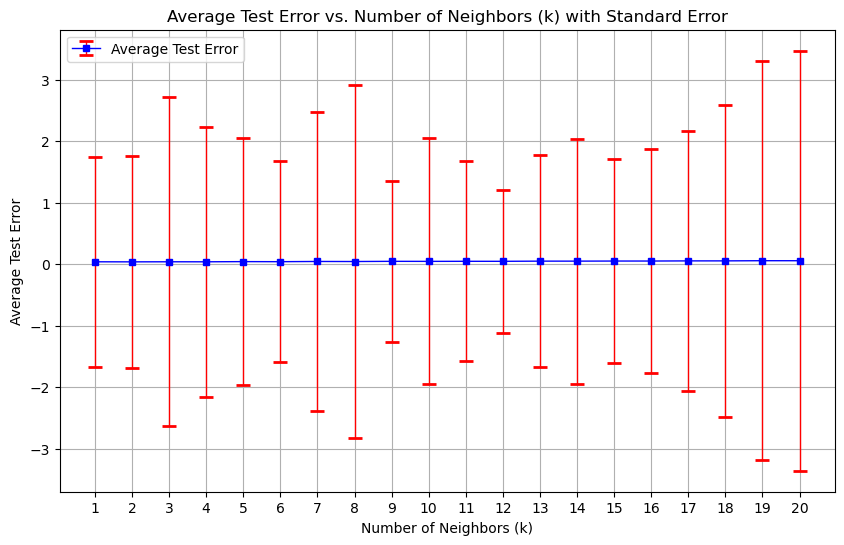

In [14]:
def k_fold_cross_validation_knn(X, y, k_range=range(1, 21), folds=5):
    kf = KFold(n_splits=folds, shuffle=True, random_state=42)
    errors = {k: [] for k in k_range}
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        for k in k_range:
            predictions = nadaraya_watson_knn(X_train, y_train, X_test, k)
            loss = zero_one_loss(y_test, predictions)
            errors[k].append(loss)
    
    # Calculate average error and standard error for each k
    average_errors = {k: np.mean(errors[k]) / len(y_test) for k in k_range}
    std_errors = {k: np.std(errors[k], ddof=1) / np.sqrt(len(errors[k])) for k in k_range} # Using ddof=1 for sample standard deviation
    
    return average_errors, std_errors


average_errors, std_errors = k_fold_cross_validation_knn(train_features, train_labels, k_range=k_range, folds=5)


ks = list(k_range)
average_errors_list = [average_errors[k] for k in ks]
std_errors_list = [std_errors[k] for k in ks]

plt.figure(figsize=(10, 6))
plt.errorbar(ks, average_errors_list, yerr=std_errors_list, fmt='-o', capsize=5, capthick=2, ecolor='r', color='blue', marker='s', markersize=5, linestyle='-', linewidth=1, label='Average Test Error')
plt.title('Average Test Error vs. Number of Neighbors (k) with Standard Error')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Average Test Error')
plt.xticks(ks)
plt.legend()
plt.grid(True)
plt.show()

**4.Apply the one-standard error rule to select a final value for 'k'.**

In [15]:
# Assuming average_errors and std_errors have been calculated

# Step 1: Identify the Best Model
min_error_k = min(average_errors, key=average_errors.get)
min_error = average_errors[min_error_k]
min_error_std = std_errors[min_error_k]

# Step 2: Apply the One-Standard Error Rule
threshold = min_error + min_error_std
candidates = {k: error for k, error in average_errors.items() if error <= threshold}

# Simplicity is defined by larger k values in k-NN
final_k = max(candidates, key=int)
print(f"Selected k according to the one-standard error rule: {final_k}")


Selected k according to the one-standard error rule: 20


**5. Fit a final k-NN model using the full training data set and using the selected value for 'k'.**

In [16]:
# Define the k-NN model with Nadaraya-Watson kernel using the selected k
def nadaraya_watson_knn_final(X_train, y_train, X_test, k):
    distances = pairwise_distances(X_test, X_train, metric='euclidean')
    knn_indices = np.argsort(distances, axis=1)[:, :k]
    knn_labels = y_train[knn_indices]
    weights = 1 / (distances[np.arange(distances.shape[0])[:, None], knn_indices] + 1e-5)
    weighted_labels = np.array([np.argmax(np.bincount(labels, weights=weight)) for labels, weight in zip(knn_labels, weights)])
    return weighted_labels

# Fit the model on the full training set
final_k_predictions = nadaraya_watson_knn_final(train_features, train_labels, test_features, final_k)

# Evaluate the model (optional)
# Here we use zero-one loss as an example of evaluation metric
final_model_error = zero_one_loss(test_labels, final_k_predictions)
final_model_accuracy = 1 - (final_model_error / len(test_labels))

print(f"Final k-NN model with k={final_k} has an accuracy of {final_model_accuracy:.4f} on the test set.")


Final k-NN model with k=20 has an accuracy of 0.9228 on the test set.


**6.Using the test data set, compute a confusion matrix and an estimate of conditional test error (using the zero-one loss).**

In [19]:
conf_matrix = confusion_matrix(test_labels, final_k_predictions)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[354   0   2   0   1   0   1   0   0   1]
 [  0 257   0   0   3   0   3   0   0   1]
 [  8   2 175   2   1   0   3   2   5   0]
 [  4   0   2 151   0   3   0   1   3   2]
 [  1   3   4   0 168   0   2   2   0  20]
 [  8   0   2   5   0 135   1   0   4   5]
 [  2   1   3   0   2   1 161   0   0   0]
 [  0   4   1   0   4   0   0 133   2   3]
 [  4   1   0   5   0   2   2   2 148   2]
 [  1   1   0   0   1   0   0   2   2 170]]


In [20]:
def conditional_test_error(y_true, y_pred):
    unique_labels = np.unique(y_true)
    conditional_errors = {}
    for label in unique_labels:
        label_mask = y_true == label
        conditional_errors[label] = np.sum(y_pred[label_mask] != y_true[label_mask]) / np.sum(label_mask)
    return conditional_errors

# Compute Conditional Test Error
conditional_errors = conditional_test_error(test_labels, final_k_predictions)
print("Conditional Test Errors by Class:\n", conditional_errors)


Conditional Test Errors by Class:
 {0: 0.013927576601671309, 1: 0.026515151515151516, 2: 0.11616161616161616, 3: 0.09036144578313253, 4: 0.16, 5: 0.15625, 6: 0.052941176470588235, 7: 0.09523809523809523, 8: 0.10843373493975904, 9: 0.03954802259887006}
